In [1]:
import pandas as pd

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Perceptron
from sklearn.metrics import accuracy_score
import numpy as np
from matplotlib import font_manager, rc # 폰트 세팅을 위한 모듈 추가
import matplotlib.pyplot as plt 
import seaborn as sns
# matplotlib이 한글을 읽을 수 있도록 변경  
plt.rcParams['axes.unicode_minus'] = False
font_path = "C:/Windows/Fonts/malgun.ttf" # 사용할 폰트명 경로 삽입
font = font_manager.FontProperties(fname = font_path).get_name()
rc('font', family = font)

#파일을 읽어옴
df = pd.read_excel("./DS.xlsx")

# <군집분석>

### 1. 데이터 전처리
#### 1) '분위수' 관련 column 삭제

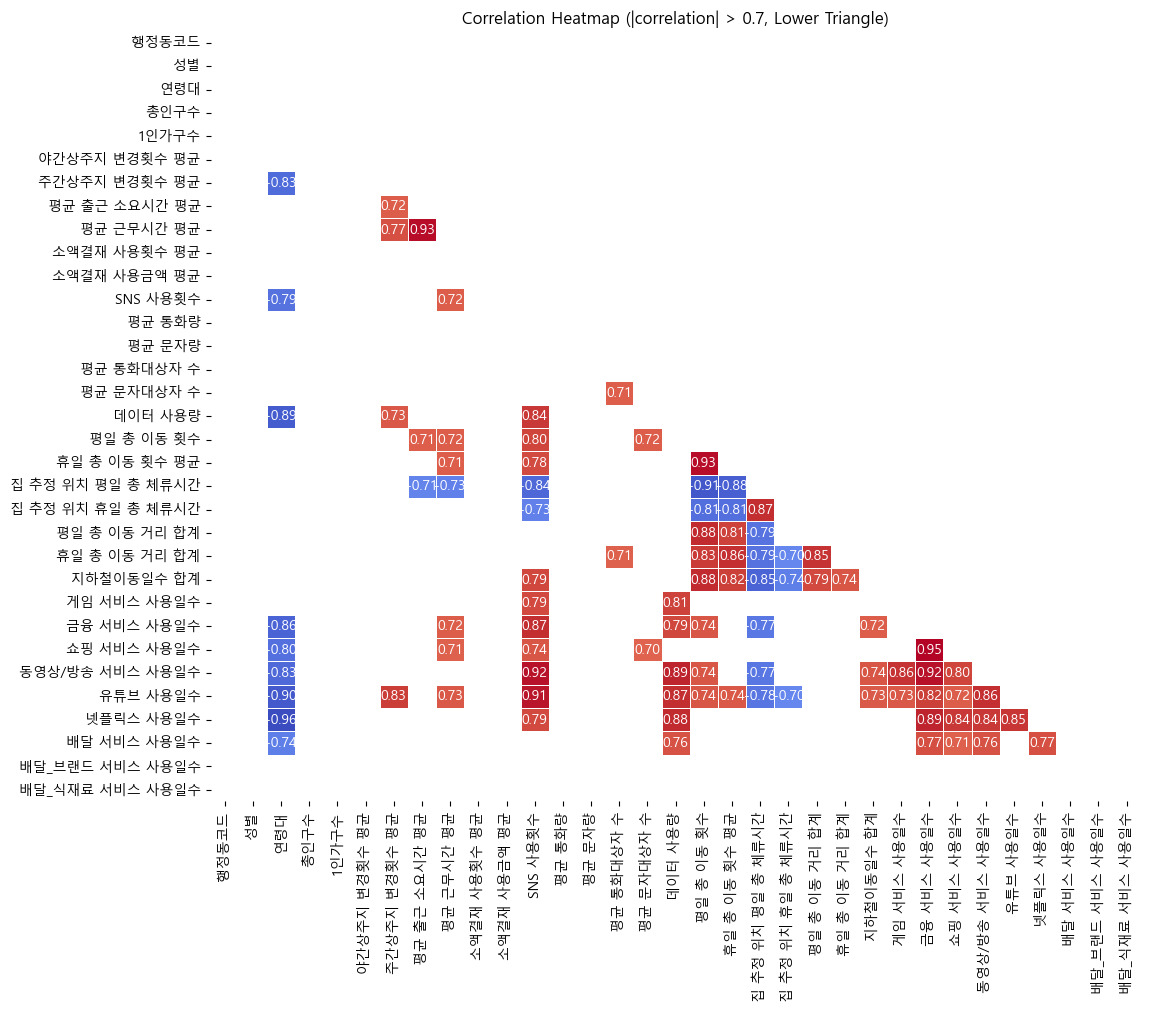

In [2]:
# '분위수'관련 column 삭제
# 추출할 열의 인덱스 리스트 => 구글 문서에 열 이름 별 인덱스 적어놓음!!
column_indices = [0, 3, 4, 5, 6, 8, 13, 18, 23, 28, 33, 39, 43, 47, 51, 55, 59, 64, 69, 74, 79, 84, 89, 94, 99, 104, 109, 114, 119, 124, 129, 134, 139]

# 열 이름 추출
column_names = [df.columns[i] for i in column_indices if i < len(df.columns)]

# 추출된 열들로 새로운 데이터프레임 생성
df_selected = df[column_names]

# 상관행렬 계산
correlation_matrix = df_selected.corr()

# 상위 삼각형 마스킹 배열 생성 => 하위 삼각형만 보기 위해서
mask_upper = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# 상관 계수의 절대값이 0.7 이하인 값들을 마스크 처리 => 상관계수 절댓값이 0.7 이상인 것들만 모아 볼 수 있도록
mask_correlation = np.abs(correlation_matrix) < 0.7

# 두 마스크를 결합
mask_combined = mask_upper | mask_correlation

# 마스크된 값을 NaN으로 변환 (히트맵에서 보이지 않도록)
correlation_matrix = correlation_matrix.mask(mask_combined)

# 히트맵 시각화
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5, mask=mask_upper, cbar=False)
plt.title('Correlation Heatmap (|correlation| > 0.7, Lower Triangle)')
plt.show()

- (배달 서비스 사용일수)에 대한 상관계수가 0.7 이상인 것들[column_num]: 연령대[4], 데이터 사용량[59], 금융서비스 사용일수[104], 쇼핑 서비스 사용일수[109], 동영상/방송 서비스 사용일수[114], 넷플릭스 사용일수[124] => 총 6개(4, 59, 104, 109, 114, 124 번째 열)

#### 2) PCA 주성분 하이퍼파라미터 적절한 것 찾기

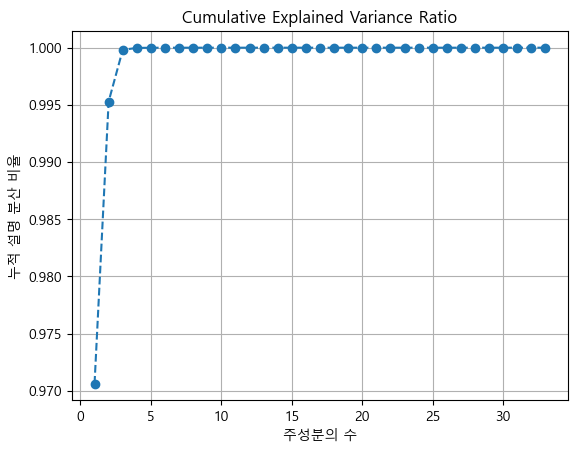

In [3]:
from sklearn.decomposition import PCA

# 첫 번째 행을 열 이름으로 설정
df.columns = df.iloc[0]

# 첫 번째 행은 제외하고 데이터 선택
selected_data = df.iloc[1:, column_indices].astype(float)

# PCA 객체 생성
pca = PCA()

# PCA 수행
pca.fit(selected_data)

# 누적 설명 분산 계산
explained_variance_ratio_cumulative = np.cumsum(pca.explained_variance_ratio_)

# 누적 설명 분산 시각화
plt.plot(range(1, len(explained_variance_ratio_cumulative) + 1), explained_variance_ratio_cumulative, marker='o', linestyle='--')
plt.xlabel('주성분의 수')
plt.ylabel('누적 설명 분산 비율')
plt.title('Cumulative Explained Variance Ratio')
plt.grid(True)
plt.show()

- 주성분의 수를 선택하는 기준은 데이터의 분산을 얼마나 잘 설명하는지에 달려 있고, 일반적으로 총 분산의 70-90%를 설명하는 주성분의 수를 선택.
- 이를 확인하기 위해 각 주성분이 설명하는 분산 비율을 살펴보고, 누적 분산 비율을 계산합니다.
- =>주성분의 수가 3일때(n_components=3) PCA의 효과가 좋다고 판단

### 2. K-means 군집 분석

c:\users\hk-lee\appdata\local\programs\python\python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


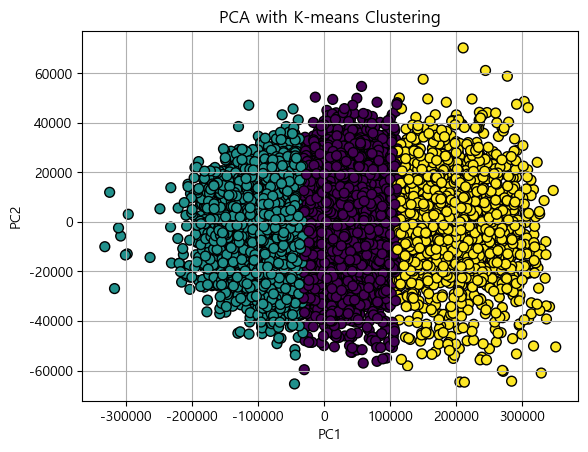

In [4]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


# 첫 번째 행을 열 이름으로 설정
df.columns = df.iloc[0]

# 첫 번째 행은 제외하고 데이터 선택
selected_data = df.iloc[1:, column_indices].astype(float)

# PCA 수행
pca = PCA(n_components=3)
pca_result = pca.fit_transform(selected_data)

# K-means 클러스터링 수행
kmeans = KMeans(n_clusters=3)
clusters = kmeans.fit_predict(pca_result)

# 클러스터링 결과 시각화
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=clusters, cmap='viridis', marker='o', edgecolor='k', s=50)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA with K-means Clustering')
plt.grid(True)
plt.show()